# Showcase of XGBoost

As the title says, this is a showcase of XGBoost.  
For actual documentation, refer to the [xgboost documentation](https://xgboost.readthedocs.org/en/latest/).

For other used classification methods, refer to showcase_sklearn.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import toolbox as tb

Like other classifiers, we test XGBoost first with toy data.

Populating the interactive namespace from numpy and matplotlib


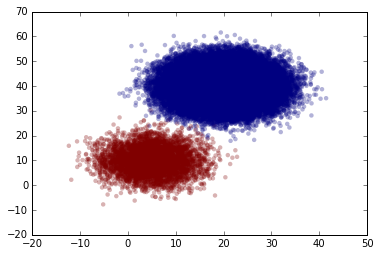

In [2]:
n = 100000
toy_data = tb.createToyData(n,dim = 4,s_prob = 0.05)
toy_weights = toy_data[:,0]
toy_labels = toy_data[:,1]
x = toy_data[:,2:4]

%pylab inline
plt.scatter(x[:,0], x[:,1], edgecolor="", c=toy_labels, alpha=0.3)

Again, we split the toy data into a training set and a test set.

In [3]:
n_train = int(n/10)

toy_train_x = x[:n_train]
toy_test_x = x[n_train:]

toy_train_labels = toy_labels[:n_train]
toy_test_labels  = toy_labels[n_train:]

toy_train_weights = toy_weights[:n_train] 
toy_test_weights = toy_weights[n_train:]

tb.calcMaxAMS(toy_test_weights,toy_test_labels);

Found 4625 signals.
Weightsums signal: 115.225750059 | background: 0
Maximum AMS possible with this Data: 20.064220276790543


Now we try out XGBoost.

In [4]:
import xgboost as xgb

We construct a data matrix for XGBoost.  
As it was initially developed for [The Higgs Boson Machine Learning Challenge](https://www.kaggle.com/c/higgs-boson), it is possible to parse a flag for missing values. This is in our case `-999.0`.

For making predictions using XGBoost, we draw inspiration from a participant of the challenge. He shared his [code](https://github.com/phunterlau/kaggle_higgs) in the Kaggle forum.

In [5]:
xgmat = xgb.DMatrix(toy_train_x, label=toy_train_labels, missing = -999.0, weight=toy_train_weights)

In [6]:
# setup parameters for xgboost
param = {}
param['objective'] = 'binary:logitraw'
param['eta'] = 0.1
param['max_depth'] = 3
param['subsample'] = 0.9

param['silent'] = 1
param['nthread'] = 8

param['eval_metric'] = 'error'

We can observe XGBoost's training process by using a watchlist, 

In [7]:
watchlist = [(xgmat,'train')]
bst = xgb.train( param, xgmat, 10 , watchlist);

[0]	train-error:0.002444
[1]	train-error:0.002444
[2]	train-error:0.002444
[3]	train-error:0.000044
[4]	train-error:0.000044
[5]	train-error:0.000044
[6]	train-error:0.000044
[7]	train-error:0.000044
[8]	train-error:0.000044
[9]	train-error:0.000044


With a fitted model, we can make predictions for the test data. Again, we need to provide the data as data matrix.

In [8]:
xgmat = xgb.DMatrix( toy_test_x, missing = -999.0 )
pred = bst.predict( xgmat )

In [9]:
toy_events = np.arange(1,(len(toy_test_x)+1))

In [10]:
res = np.vstack((toy_events,pred)).transpose()

In [11]:
res

array([[  1.00000000e+00,   1.13603401e+00],
       [  2.00000000e+00,   1.13603401e+00],
       [  3.00000000e+00,  -1.51979339e+00],
       ..., 
       [  8.99980000e+04,  -1.51979339e+00],
       [  8.99990000e+04,  -1.51979339e+00],
       [  9.00000000e+04,  -1.51979339e+00]])

The results delivered by the package are given as scores. 
We need to process this into a hard prediction by split the data at a certain point. In this case, we classify the top 5% of the data as `1`.

In [12]:
ntop = int( (1-0.05) * len(res) )
res = tb.sortByColumn(res,1)

res[:ntop,1] = 0
res[ntop:,1] = 1

res = tb.sortByColumn(res,0)
hard_pred = res[:,1]

Populating the interactive namespace from numpy and matplotlib


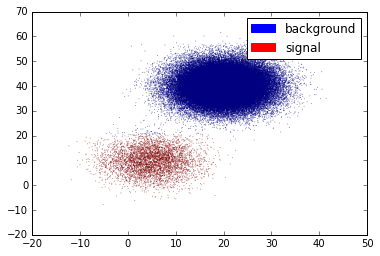

In [13]:
%pylab inline

xData = toy_test_x[:,0]
yData = toy_test_x[:,1]

scat = plt.scatter(xData, yData, s=1, edgecolor="", c=hard_pred, alpha=0.5)  

blue_patch = mpatches.Patch(color='blue', label='background')
red_patch = mpatches.Patch(color='red', label='signal')
plt.legend(handles=[blue_patch,red_patch])

## Classfication with Kaggle data

As we generate submissions in this showcase, we need to import the Kaggle dataset.  
We only extract the whole feature set, as it was the best set for XGBoost.

In [14]:
import kaggleData as kD
csv_data,csv_header = kD.csvToArray()
train_data,train_header,test_data,test_header=kD.getOriginalKaggleSets(csv_data,csv_header)
sol_data,sol_header = kD.getSolutionKey(csv_data,csv_header)
test_events = kD._extractFeature("EventId",test_data,csv_header).astype(float)

In [15]:
train_all = train_data[:,1:-2].astype(float)
train_labels = kD.translateLabels(train_data[:,-1],["Label"]).astype(float)
train_weights = train_data[:,-2].astype(float)
test_all = test_data[:,1:].astype(float)
header_all = test_header[1:]

We setup multiple functions to run tests more efficiently.  
As XGBoost provides the option to save fitted models, it makes sense to separate training and prediction.

We want to save the models in a specified folder.

In [16]:
import os
scriptFolderPath = os.path.dirname(os.getcwd())
mainFolderPath = os.path.dirname(scriptFolderPath)
modelPath = (mainFolderPath + "/data/xgbmodels/")

Also we want to record runtime.

In [17]:
import time

In [18]:
def xgbmodel(data,label,weight,trees=100,depth=9,eta=0.1,timed=False):
    
    # XGBoost is able to be fitted with respect to AMS. If we use the Kaggle data, we need to rescale the weights.
    weight = weight * float(550000) / len(label)

    sum_wpos = sum( weight[i] for i in range(len(label)) if label[i] == 1.0  )
    sum_wneg = sum( weight[i] for i in range(len(label)) if label[i] == 0.0  )
       
    # We construct a data matrix for XGBoost and flag -999.0 as missing value.
    xgmat = xgb.DMatrix( data, label=label, missing = -999.0, weight=weight )
    
    """setup parameters for xgboost"""
    
    param = {}
    # use logistic regression loss, use raw prediction before logistic transformation
    # since we only need the rank
    param['objective'] = 'binary:logitraw'
    
    # scale weight of positive examples
    param['scale_pos_weight'] = sum_wneg/sum_wpos
    
    # parameters for decision trees
    param['eta'] = eta
    param['max_depth'] = depth
    param['subsample'] = 0.9
    
    param['silent'] = 1
    param['nthread'] = 8
    
    # We want to watch multiple metrics. 
    param['eval_metric'] = 'auc'
    plst = list(param.items())+[('eval_metric', 'ams@0.14')]    
    
    # comment out if you don't want to observe the training process
    watchlist = [ (xgmat,'train') ]
    print ('loading data end, start to boost trees')
    
    # performance testing
    x_time = 0.
    if timed:
        start = time.time()
    
    # delete watchlist of not initialized in previous section
    bst = xgb.train( plst, xgmat, trees, watchlist );
    
    if timed:
        end = time.time()
        x_time = end - start
    
    # perform cross-validation
    cval = xgb.cv(plst,xgmat)
    
    # save this model
    bst.save_model(modelPath + 'higgs_%dtrees_depth%s.xgb'%(trees,depth))
    
    return cval,x_time

We create the prediction method to be able to load models with names of the previously specified format.

In [19]:
def xgbpredict(tdata,trees=100,depth=9,timed=False):
    
    #load up saved model
    modelfile = str(modelPath + 'higgs_%dtrees_depth%s.xgb'%(trees,depth))
    bst = xgb.Booster({'nthread':8})
    bst.load_model( modelfile )
    
    # We construct a data matrix for XGBoost and flag -999.0 as missing value.
    xgmat = xgb.DMatrix( tdata, missing = -999.0 )
    
    # performance testing    
    x_time = 0.
    if timed:
        start = time.time()
    
    soft_pred = bst.predict( xgmat )
    
    if timed:
        end = time.time()
        x_time = end - start
    
    return soft_pred,x_time

We have a method in toolbox.py to threshold our prediction by rank.  
To mimic the run methods we created for other classifiers, we need to create a threshold method specifically for XGBoost.

We could do this for other classifiers, but testing of this thresholding on them resulted to worse AMS.

In [20]:
def threshPred(events,pred,threshold=0.86):
    
    #link event IDs to predictions
    res = np.vstack((events,pred)).transpose()
    
    #sort resolution w.r.t. prediction scores
    res = tb.sortByColumn(res,1)

    #threshold by percentual rank
    ntop = int( (threshold) * len(res) )
    res[:ntop,1] = 0
    res[ntop:,1] = 1

    #sort thresholded resolution w.r.t. IDs and return prediction
    res = tb.sortByColumn(res,0)
    hard_pred = res[:,1]
    
    return hard_pred

Now we created all tools needed for running tests. Analogous to other classifiers we create `run_xgb()`.

In [21]:
def run_xgb(train_data,labels,weights,test_data,events,timed=False,trees=100,depth=9,eta=0.1,threshold=0.855,featListName="not specified"):

    #training classifier
    cvs,time_train = xgbmodel(train_data,labels,weights,trees,depth,eta,timed)
    
    #make soft prediction
    soft_pred,time_test = xgbpredict(test_data,trees,depth,timed)
    
    #threshold soft prediction
    hard_pred = threshPred(events,soft_pred,threshold)
    
    #calculate AMS and report it to user
    b_ams,v_ams = tb.calcSetAMS(hard_pred,sol_data)
    print("Public AMS:",b_ams[0],"|| Private AMS:",v_ams[0],"|| Threshold:", threshold)
    
    #save run-stats, we save trees as "steps_" due to an misunderstanding when the record file was initially created.
    res=np.empty((20,),dtype="<U16")
    res[:14]=["xgboost",
            featListName,
            str(cvs),
            str(b_ams[0]),
            str(v_ams[0]),
            str(time_train),
            str(time_test),
            str("threshold="+str(threshold)),
            str("steps_="+str(trees)),
            str("depth_="+str(depth)),
            str("eta_="+str(eta)),
            str("subsample_=0.9"),
            str("eval_1=auc"),
            str("eval_2=ams@0.14"),
            ]
            
    res[14:]="None"
    tb.recordRun(res)
    
    return hard_pred,soft_pred

We use the parameters that produced our best submission, measured by public AMS.

In [22]:
rec_data ,rec_header = tb.getRecord()
rec_pubams=tb.sortByColumn(rec_data,3)
rec_pubams[-1]

array(['xgboost', 'header_all', '2.4321543', '3.66421262680941',
       '3.71268472156738', '997.632616996765', '57.4933519363403',
       'Threshold=0.145', 'steps_=2500', 'depth_=9', 'eta_=0.01',
       'subsample_=0.9', 'eval_1=auc', 'eval_2=ams@0.14', 'None', 'None',
       'None', 'None', 'None', 'None'], 
      dtype='<U16')

The output for following cell has been cleared, as it produces 2500 rows of data.  
(Github renders full output)

In [ ]:
pred = run_xgb(train_all,train_labels,train_weights,test_all,test_events,timed=True,trees=2500,depth=9,eta=0.01,threshold=0.855,featListName="header_all")[1]

In [24]:
tb.createSubmissionFile(pred,"subm_xgb.csv",threshold = 0.855, rankThreshold = True)

## Recreating Figure 5

XGBoost provides an easy way to plot decision trees, `plot_tree()`.  
This function requires `graphviz` for Python.

We load the xgb model used for this figure.

In [25]:
bst = xgb.Booster({'nthread':8})
bst.load_model(str(modelPath + 'higgs_100trees_depth3.xgb'))

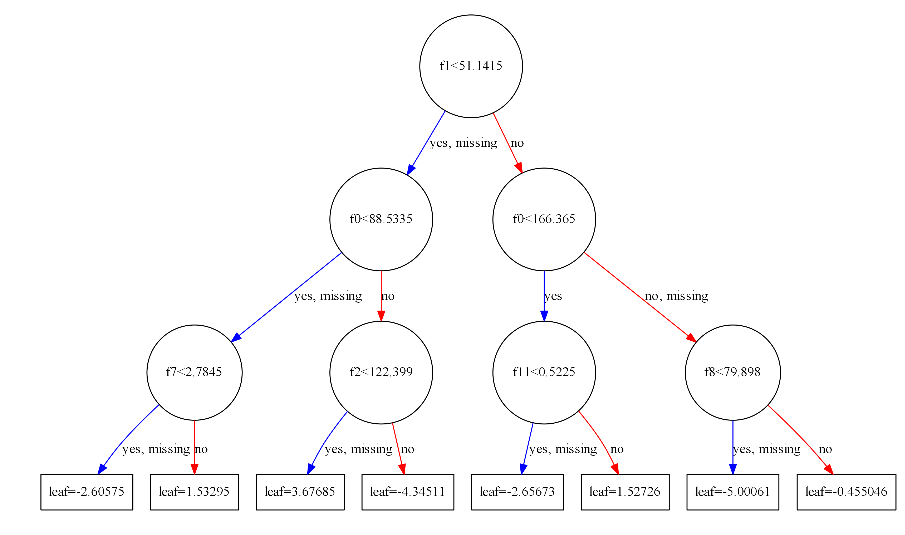

In [27]:
mainFig = plt.figure(figsize = (16,9))
ax = mainFig.add_subplot(111)

#every parameter after ax is parsed to the used graphviz method, use with caution
xgb.plot_tree(bst, num_trees=0,ax=ax,dpi="270.0")

#saving path
plotPath = (mainFolderPath + "/plots/")

#uncomment if you want the plot to be saved
#mainFig.savefig(str(plotPath+"tree.pdf"),format="pdf",dpi=270)